# Creating a mono-objective algorith to find the optimal construction localization of new supermarkets in a city

## Create the classes and functions for the mono-objective algorithm

In [0]:
import sys
import time
import random
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import heapq
from itertools import combinations 

### Individual Class

In [0]:
class Individual(object):   
   
    def __init__(self, chromosome, size):
            self.chromosome = chromosome[:]
            self.allele_pool = allele_pool
            self.fitness = -1
            self.fitness_sep = [-1,-1,-1,-1]
            
    def crossover_onepoint(self, other):
        c = random.randrange(len(self.chromosome))
        if len((set(self.chromosome[:c]) & set(other.chromosome[c:])))==0:
          ind1 = Individual(self.chromosome[:c] + other.chromosome[c:], allele_pool)
          ind2 = Individual(other.chromosome[:c] + self.chromosome[c:], allele_pool)
          return [ind1, ind2]
        else:
          return [self, other]   
    
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1, allele_pool)
        ind2 = Individual(chromosome2, allele_pool)
        return [ind1, ind2] 

    def mutate_position(self): 
        """       Bit flip  """
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome)) 
        newAllele = allele_pool[random.randrange(0,len(allele_pool))]
        mutated_chromosome[mutGene] = newAllele
        return Individual(mutated_chromosome, allele_pool)
        
    def mutate_swap(self):
        mutated_chromosome = deepcopy(self.chromosome)
        mutGen1 = random.randrange(0,len(mutated_chromosome))
        mutGen2 = random.randrange(0,len(mutated_chromosome))
        temp = allele_pool[mutGen1]
        if temp not in mutated_chromosome:
          mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome, allele_pool)     

### Population Functions

In [0]:
def init_population(pop_number, chromosome_size, allele_pool):    
    num_alleles = len(allele_pool)
    population = []
    for i in range(pop_number):
        new_chromosome = [allele_pool[random.randrange(0, num_alleles)] for j in range(chromosome_size)]
        population.append(Individual(new_chromosome, allele_pool) )
    return population

### Fitness evaluation

In [0]:
def fun_fitness_cuad(cromosoma):
    n = 0
    for c in cromosoma:
      n +=  pob_pool[c]

    comb = combinations(cromosoma, 2) 
    dist_x = 0
    dist_y = 0
    for com in comb:
      dist_x += abs(x_pool[com[0]] - x_pool[com[1]])
      dist_y += abs(y_pool[com[0]] - y_pool[com[1]])
    total = dist_x + dist_y + n

    return total

In [0]:
def fun_fitness_cuad_sep(cromosoma):
    n = 0
    for c in cromosoma:
      n +=  pob_pool[c]

    comb = combinations(cromosoma, 2) 
    dist_x = 0
    dist_y = 0
    for com in comb:
      dist_x += abs(x_pool[com[0]] - x_pool[com[1]])
      dist_y += abs(y_pool[com[0]] - y_pool[com[1]])
    total = dist_x + dist_y + n

    return [total,dist_x, dist_y,n]

In [0]:
def evaluate_population(population,fitness_fn): 
    for i in range(len(population)):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)
            population[i].fitness_sep = fun_fitness_cuad_sep(population[i].chromosome)
    return population

### Display the population

In [0]:
def display(population):
    listaAG=[]
    for i in range(len(population)):
      listaAG.append([population[i].chromosome,population[i].fitness,population[i].fitness_sep[1],population[i].fitness_sep[2],population[i].fitness_sep[3]])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness acumulado', 'Distancias X', 'Distancias Y', 'Población Acumulada']
    return data

### Parent Selection

####  Roulette

In [0]:
def select_parents_roulette(population):
    popsize = len(population)
  
    sumfitness = sum([indiv.fitness for indiv in population])
    pickfitness = random.uniform(0, sumfitness)  
    cumfitness = 0   
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break

    sumfitness = sumfitness - population[iParent1].fitness
    pickfitness = random.uniform(0, sumfitness)  
    cumfitness = 0  
    for i in range(popsize):
        if i == iParent1: continue 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Tourney

In [0]:
def select_parent_torneo(population,size_torneo):
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    iParent1=np.argmax(list_indiv)
    
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

## Create a new population and test the functions

### X and Y cordinates of the supermarkets and number of citizens in the area

In [0]:
x_pool = [-12.04861,-12.05956,-12.06524,-12.05998,-12.05541,-12.05417,-12.05349,-12.05268,-12.05278,-12.05301,-12.04937,-12.05465,-12.05486,-12.05059,-12.04253,-12.04817,-12.04668,-12.05606,-12.07258,-12.07414,-12.06771,-12.06921,-12.07396,-12.075,-12.09086,-12.09375,-12.09602,-12.02669,-12.0282,-12.03267,-12.03828,-12.03982,-12.04117,-12.0417,-12.04155,-12.03882,-12.03959,-12.03548,-12.03766,-12.03984,-12.04233,-12.04328,-12.04486,-12.04566,-12.03895,-12.12916,-12.13156,-12.13222,-12.1265,-12.1261,-12.12603,-12.12587,-12.12248,-12.12326,-12.12028,-12.1201,-12.12532,-12.12116,-12.12159,-12.11685]
y_pool = [-77.06496,-77.07583,-77.07334,-77.063,-77.07497,-77.07472,-77.07362,-77.07409,-77.07104,-77.07735,-77.07948,-77.06952,-77.07655,-77.07666,-77.09595,-77.05867,-77.0726,-77.06726,-77.06884,-77.0629,-77.06214,-77.0593,-77.051,-77.04631,-77.05947,-77.06947,-77.07398,-76.88958,-76.8912,-76.91418,-76.9157,-76.91897,-76.9186,-76.9221,-76.9213,-76.9238,-76.92422,-76.92502,-76.92863,-76.92827,-76.92739,-76.92851,-76.92715,-76.91841,-76.92025,-77.02984,-77.02371,-77.02358,-77.02697,-77.02889,-77.03129,-77.03583,-77.03332,-77.03639,-77.03866,-77.0343,-77.03135,-77.02889,-77.03092,-77.02991]
pob_pool = [16500,18000,17000,15000,17100,17350,17300,17400,17350,17400,16900,17200,17300,17500,18500,17100,16400,15950,16800,16950,14500,16400,17300,17000,14900,13900,11500,2900,2500,2000,3800,8500,7500,6000,6000,8600,8500,9200,9900,9900,9200,8700,7900,4000,8600,16000,15800,15600,18400,18800,18300,14500,17900,16950,17600,19000,18600,18000,18500,20000]

### Create a new population

In [11]:
num_individuals = 100
ind_size        = 10
allele_pool = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59]

population = init_population(num_individuals,ind_size, allele_pool)
display(population)


,Poblacion,fitness acumulado,Distancias X,Distancias Y,Población Acumulada
0,"[35, 20, 28, 26, 5, 53, 9, 10, 34, 53]",-1,-1,-1,-1
1,"[30, 41, 36, 4, 4, 17, 22, 59, 33, 21]",-1,-1,-1,-1
2,"[20, 42, 43, 49, 55, 34, 12, 26, 36, 24]",-1,-1,-1,-1
3,"[49, 40, 15, 22, 31, 31, 15, 27, 50, 17]",-1,-1,-1,-1
4,"[34, 22, 39, 31, 6, 40, 54, 50, 47, 25]",-1,-1,-1,-1
...,...,...,...,...,...
95,"[37, 58, 40, 16, 28, 19, 37, 36, 56, 29]",-1,-1,-1,-1
96,"[38, 10, 10, 5, 37, 58, 47, 56, 24, 41]",-1,-1,-1,-1
97,"[36, 26, 37, 16, 43, 51, 59, 25, 49, 37]",-1,-1,-1,-1
98,"[29, 6, 55, 40, 17, 38, 10, 43, 31, 39]",-1,-1,-1,-1


### Evaluate the first population

In [12]:
fitness_fn=fun_fitness_cuad
population=evaluate_population(population,fitness_fn) 
display(population)

,Poblacion,fitness acumulado,Distancias X,Distancias Y,Población Acumulada
0,"[35, 20, 28, 26, 5, 53, 9, 10, 34, 53]",128655.45514,1.77515,3.67999,128650
1,"[30, 41, 36, 4, 4, 17, 22, 59, 33, 21]",130854.75579,1.12361,3.63218,130850
2,"[20, 42, 43, 49, 55, 34, 12, 26, 36, 24]",122405.31668,1.73269,3.58399,122400
3,"[49, 40, 15, 22, 31, 31, 15, 27, 50, 17]",133655.35880,1.71005,3.64875,133650
4,"[34, 22, 39, 31, 6, 40, 54, 50, 47, 25]",133605.38928,2.00331,3.38597,133600
...,...,...,...,...,...
95,"[37, 58, 40, 16, 28, 19, 37, 36, 56, 29]",111055.25552,1.72616,3.52936,111050
96,"[38, 10, 10, 5, 37, 58, 47, 56, 24, 41]",146555.29058,2.00510,3.28548,146550
97,"[36, 26, 37, 16, 43, 51, 59, 25, 49, 37]",126005.52725,2.03276,3.49449,126000
98,"[29, 6, 55, 40, 17, 38, 10, 43, 31, 39]",112654.65265,1.01594,3.63671,112650


 ### Testing the selection operators

In [13]:
size_torneo = 3

winner1,winner2=select_parent_torneo(population,size_torneo)
print(winner1.chromosome,winner1.fitness)
print(winner2.chromosome,winner2.fitness)

[18, 6, 46, 5, 4, 16, 45, 15, 39, 51] 158253.8666
[38, 10, 10, 5, 37, 58, 47, 56, 24, 41] 146555.29058


In [14]:
winner1,winner2=select_parents_roulette(population)
print(winner1.chromosome,winner1.fitness)
print(winner2.chromosome,winner2.fitness)

[3, 8, 34, 14, 25, 39, 53, 29, 3, 24] 129504.97225
[41, 47, 27, 59, 37, 1, 37, 50, 25, 4] 132905.90885


### Testing the crossover

In [0]:
popsize = len(population)
mating_pool = []
for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 

In [0]:
offspring_population = []
for i in range(len(mating_pool)): 
    offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )

In [17]:
display(offspring_population)

,Poblacion,fitness acumulado,Distancias X,Distancias Y,Población Acumulada
0,"[5, 33, 41, 29, 51, 14, 0, 17, 15, 59]",-1.0,-1.0,-1.0,-1
1,"[19, 17, 13, 24, 31, 4, 48, 53, 36, 4]",-1.0,-1.0,-1.0,-1
2,"[40, 9, 56, 0, 23, 13, 43, 0, 47, 25]",-1.0,-1.0,-1.0,-1
3,"[34, 22, 39, 31, 6, 40, 54, 50, 12, 0]",-1.0,-1.0,-1.0,-1
4,"[19, 17, 13, 24, 31, 4, 48, 53, 15, 30]",-1.0,-1.0,-1.0,-1
...,...,...,...,...,...
95,"[13, 41, 46, 5, 4, 16, 45, 15, 39, 51]",-1.0,-1.0,-1.0,-1
96,"[3, 27, 51, 50, 30, 24, 37, 13, 45, 47]",-1.0,-1.0,-1.0,-1
97,"[41, 39, 44, 1, 25, 47, 10, 31, 12, 6]",-1.0,-1.0,-1.0,-1
98,"[1, 32, 4, 12, 45, 46, 28, 26, 58, 3]",-1.0,-1.0,-1.0,-1


## Wrapping all together and get a solution for the problem

In [18]:
pmut=0.8

print('Ejecución\tIndividuo\tIteración\tFitness\tSuma de distancias X\tSuma de distancias Y\tSuma de población')
for ejecucion in range(0,10):
  population_iter = []
  population_best = []
  best_fitness = 0
  best_a = 0
  random.seed()
  population = init_population(num_individuals,ind_size, allele_pool)
  for a in range(0,500):
    offspring_population = []
    for i in range(len(mating_pool)): 
      offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))
    for i in range(len(offspring_population)):
      if random.uniform(0, 1) < pmut: 
          offspring_population[i] = offspring_population[i].mutate_swap()
    population_iter=evaluate_population(offspring_population,fitness_fn)

  #Torneo
  size_torneo = 3
  winner1,winner2=select_parent_torneo(population_iter,size_torneo)
  print(ejecucion + 1, winner1.chromosome, '-',winner1.fitness,winner1.fitness_sep[1],winner1.fitness_sep[2],winner1.fitness_sep[3], sep='\t' )
  

Ejecución	Individuo	Iteración	Fitness	Suma de distancias X	Suma de distancias Y	Suma de población
1	[47, 32, 5, 24, 43, 58, 40, 35, 52, 59]	-	133555.31373	2.056330000000006	3.2574000000000893	133550
2	[3, 5, 51, 50, 25, 47, 10, 31, 12, 6]	-	154654.00635	1.8539800000000053	2.152370000000033	154650
3	[23, 6, 3, 20, 14, 13, 21, 4, 16, 22]	-	167001.37229	0.6235199999999956	0.7487699999999933	167000
4	[18, 41, 25, 30, 56, 2, 4, 17, 44, 38]	-	130355.07831	1.4119099999999971	3.666399999999925	130350
5	[18, 6, 46, 5, 56, 2, 15, 17, 44, 38]	-	154404.38325	1.6088799999999974	2.77437000000009	154400
6	[28, 32, 58, 26, 5, 54, 19, 7, 15, 4]	-	143504.77196	1.699149999999987	3.0728100000000182	143500
7	[53, 41, 57, 4, 13, 0, 3, 6, 14, 55]	-	164553.81762	1.6592700000000136	2.1583499999999702	164550
8	[40, 9, 56, 0, 23, 13, 3, 50, 47, 25]	-	159003.89146	1.8618400000000062	2.029619999999966	159000
9	[46, 19, 0, 6, 54, 26, 45, 7, 47, 9]	-	162053.07188	1.9076499999999985	1.1642300000001313	162050
10	[23, 

### Best case scenario

In [19]:
print('Ejecución\tIndividuo\tIteración\tFitness\tSuma de distancias X\tSuma de distancias Y\tSuma de población')
best = 0
best_pop = 0
for ejecucion in range(0,10):
  population_iter = []
  population_best = []
  best_fitness = 0
  best_a = 0
  random.seed()
  population = init_population(num_individuals,ind_size, allele_pool)
  for a in range(0,500):
    offspring_population = []
    for i in range(len(mating_pool)): 
      offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))
    for i in range(len(offspring_population)):
      if random.uniform(0, 1) < pmut: 
          offspring_population[i] = offspring_population[i].mutate_swap()
    population_iter=evaluate_population(offspring_population,fitness_fn)
    max_fitness = max(map(lambda x: x.fitness, population_iter))
    i = 0
    for pop in population_iter:
      if pop.fitness == max_fitness:
        break
      else:
        i += 1
    if population_iter[i].fitness > best_fitness:
      best_fitness = population_iter[i].fitness
      population_best = population_iter[i]
      best_a = a
  if population_best.fitness > best:
    best = population_best.fitness
    best_pop = population_best
  population_best.chromosome.sort()
  print(ejecucion + 1,population_best.chromosome,best_a+1,population_best.fitness,population_best.fitness_sep[1],population_best.fitness_sep[2],population_best.fitness_sep[3], sep='\t' )


Ejecución	Individuo	Iteración	Fitness	Suma de distancias X	Suma de distancias Y	Suma de población
1	[9, 10, 15, 19, 47, 48, 50, 56, 59, 59]	146	179252.92205	1.8149999999999977	1.1070500000000152	179250
2	[5, 10, 15, 19, 47, 48, 50, 56, 59, 59]	99	179202.89784	1.8092000000000041	1.0886400000000407	179200
3	[9, 10, 15, 19, 47, 48, 50, 56, 59, 59]	162	179252.92205	1.8149999999999977	1.1070500000000152	179250
4	[8, 10, 15, 19, 47, 48, 50, 56, 59, 59]	130	179202.87903	1.8161499999999986	1.0628800000000211	179200
5	[8, 10, 15, 19, 47, 48, 50, 56, 59, 59]	7	179202.87903	1.8161499999999986	1.0628800000000211	179200
6	[6, 10, 15, 19, 47, 48, 50, 56, 59, 59]	56	179152.89354	1.8125999999999998	1.0809400000000835	179150
7	[7, 10, 15, 19, 47, 48, 50, 56, 59, 59]	425	179252.90088	1.8166499999999974	1.0842300000000336	179250
8	[4, 10, 15, 19, 47, 48, 50, 56, 59, 59]	393	178952.89339	1.802999999999999	1.0903899999999993	178950
9	[9, 10, 15, 19, 47, 48, 50, 56, 59, 59]	106	179252.92205	1.81499999999999

In [20]:
best_pop.chromosome

[9, 10, 15, 19, 47, 48, 50, 56, 59, 59]

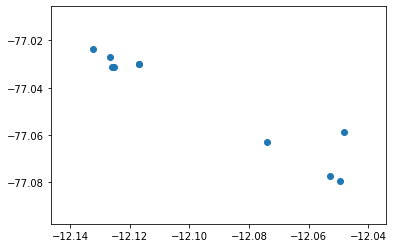

In [67]:
x = []
y = []

for ind in best_pop.chromosome:
  x.append(x_pool[ind])
  y.append(y_pool[ind])

plt.scatter(x, y)
plt.show()

In [0]:
#!apt-get install libgeos-3.5.0
#!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
#!pip install pyproj==1.9.6

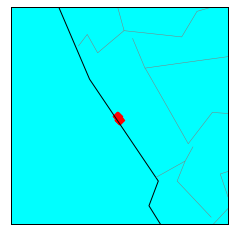

In [108]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
map = Basemap(width=500000,height=500000,projection='aeqd',
            resolution='c', lon_0 = -77.02824, lat_0 = -12.04318)

map.drawmapboundary(fill_color='aqua')
map.drawcoastlines()
#map.fillcontinents(color='#ddaa66', lake_color='aqua')
map.drawcountries()
map.drawstates(color='0.5')

x_p, y_p = map(y, x)

map.scatter(x_p, y_p, marker='D',color='r')
plt.show()

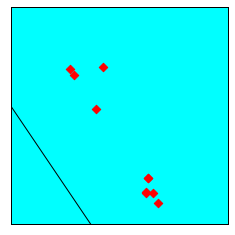

In [122]:
map = Basemap(width=15000,height=15000,projection='aeqd',
            resolution='c', lon_0 = -77.04824, lat_0 = -12.07818)

map.drawmapboundary(fill_color='aqua')
map.drawcoastlines()
#map.fillcontinents(color='#ddaa66', lake_color='aqua')
map.drawcountries()
map.drawstates(color='0.5')

x_p, y_p = map(y, x)

map.scatter(x_p, y_p, marker='D',color='r')
plt.show()